Nota: **Se usará BERT solo en una muestra pequeña para evitar problemas de hardware.**  
Para la extracción de embeddings con BERT, debido a limitaciones de hardware (sin GPU):
* Se utilizará una muestra pequeña de 200 reseñas con batch_size reducido y max_length corto para evitar que el kernel muera o se demore demasiado.
* Los demás modelos se entrenan con el conjunto completo.

# Proyecto Sprint 16

##  Introducción

### Descripción del negocio.

Film Junky Union está desarrollando un sistema para filtrar y categorizar reseñas de películas,
con el objetivo de detectar automáticamente las críticas negativas.

Para ello, utilizamos un conjunto de datos de reseñas de películas de IMDB con etiquetas 
positivas y negativas.

### Objetivo del proyecto

El objetivo es entrenar modelos de clasificación que logren un buen desempeño en la tarea, 
medido principalmente por la métrica F1, con un umbral mínimo de 0.85.

Este proyecto explora diferentes enfoques, desde modelos clásicos como regresión logística y 
potenciación de gradiente, hasta un modelo avanzado basado en BERT para extracción de características.

## Carga y Exploración de Datos 

### Carga del dataset completo y Exploración básica

In [1]:
import pandas as pd

df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')

# Información general del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [2]:
# Mostrar las primeras filas para entender la estructura
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


<div style="color: black ; background-color: LightSeaGreen">
    
* Se cargan los datos y se hace un analisis exploratorio, vemos las primeras filas para familiarizarnos con las columnas disponibles asi como el tipo de datos que se manejan.
    
* Estructura de los datasets:
47,331 filas y no hay valores nulos.

* Tipos de datos:
int, float y  object

Veamos el número de películas y reseñas a lo largo de los años.

In [3]:
import math

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')
tqdm.pandas()

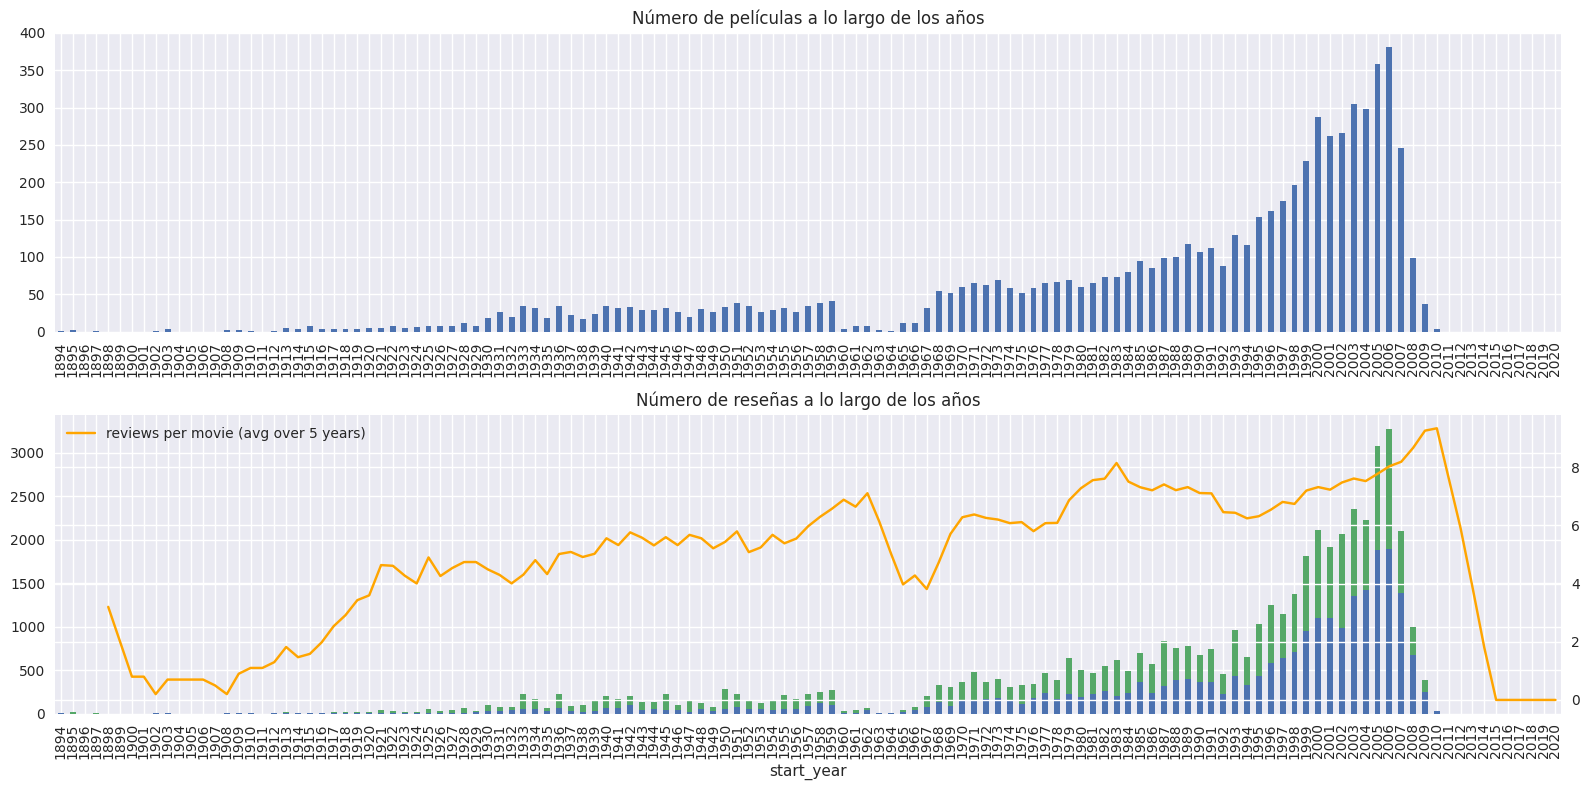

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

### Desequilibrio de clases

In [5]:
# Revisar el balance de clases en la variable objetivo 'pos'
dc_p = df['pos'].value_counts()
print('Variable objetivo: \n', dc_p)
print('\n')

# Verificar división en conjuntos de entrenamiento y prueba
dc_pa = df['ds_part'].value_counts()
print('Conjuntos de entrenamiento y prueba: \n', dc_pa)

Variable objetivo: 
 0    23715
1    23616
Name: pos, dtype: int64


Conjuntos de entrenamiento y prueba: 
 train    23796
test     23535
Name: ds_part, dtype: int64


Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

Text(0.5, 1.0, 'Gráfico KDE de #Reseñas por película')

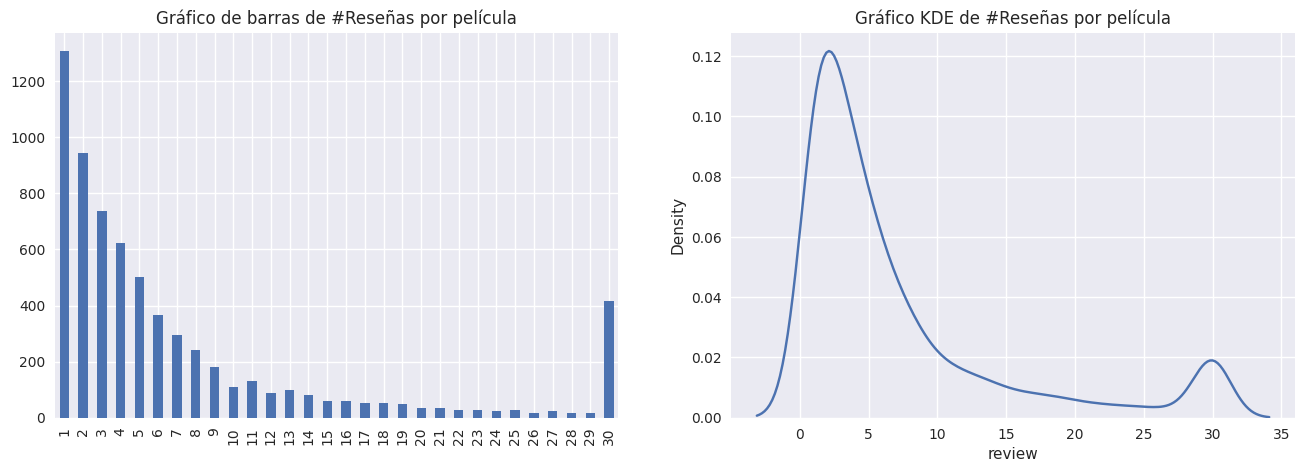

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

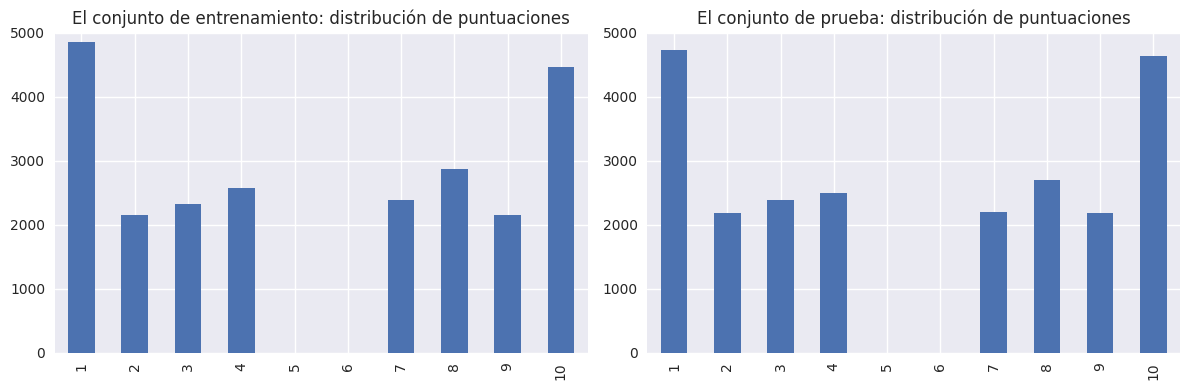

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

<div style="color: black ; background-color: LightSeaGreen"
     
* No hay un desequilibrio significativo.
* La distribución está muy balanceada (prácticamente 50/50), lo cual es ideal para entrenar modelos de clasificación.
* Puedo usarlos directamente sin hacer train_test_split().

## Preprocesamiento de Texto - Modelos Clasicos

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto.

In [8]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

### Limpieza y vectorización básica con TF-IDF simple

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Separar textos y etiquetas según ds_part
train_texts = df[df['ds_part'] == 'train']['review']
test_texts = df[df['ds_part'] == 'test']['review']
train_labels = df[df['ds_part'] == 'train']['pos']
test_labels = df[df['ds_part'] == 'test']['pos']

# Crear vectorizador TF-IDF con parámetros básicos
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,      # limitar vocabulario a 10,000 palabras
    stop_words='english',    # eliminar stopwords comunes en inglés
    max_df=0.95,             # eliminar palabras que aparecen en más del 95% de textos
    min_df=5                 # eliminar palabras que aparecen en menos de 5 textos
)

# Ajustar vectorizador solo con datos de entrenamiento y transformar
X_train = tfidf_vectorizer.fit_transform(train_texts)

# Transformar datos de prueba usando el vectorizador ajustado
X_test = tfidf_vectorizer.transform(test_texts)

<div style="color: black ; background-color: LightSeaGreen">
Para aprender y entender bien cada parte, lo que hice fue primero entrenar los modelos de forma basica para despues medir el impacto real de cada cambio (por ejemplo, qué tanto mejora la lematización con spaCy).

Esto me da claridad sobre qué hace cada paso (preprocesamiento, vectorización, modelado).
   

###  Regresión logística con TF-IDF simple

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


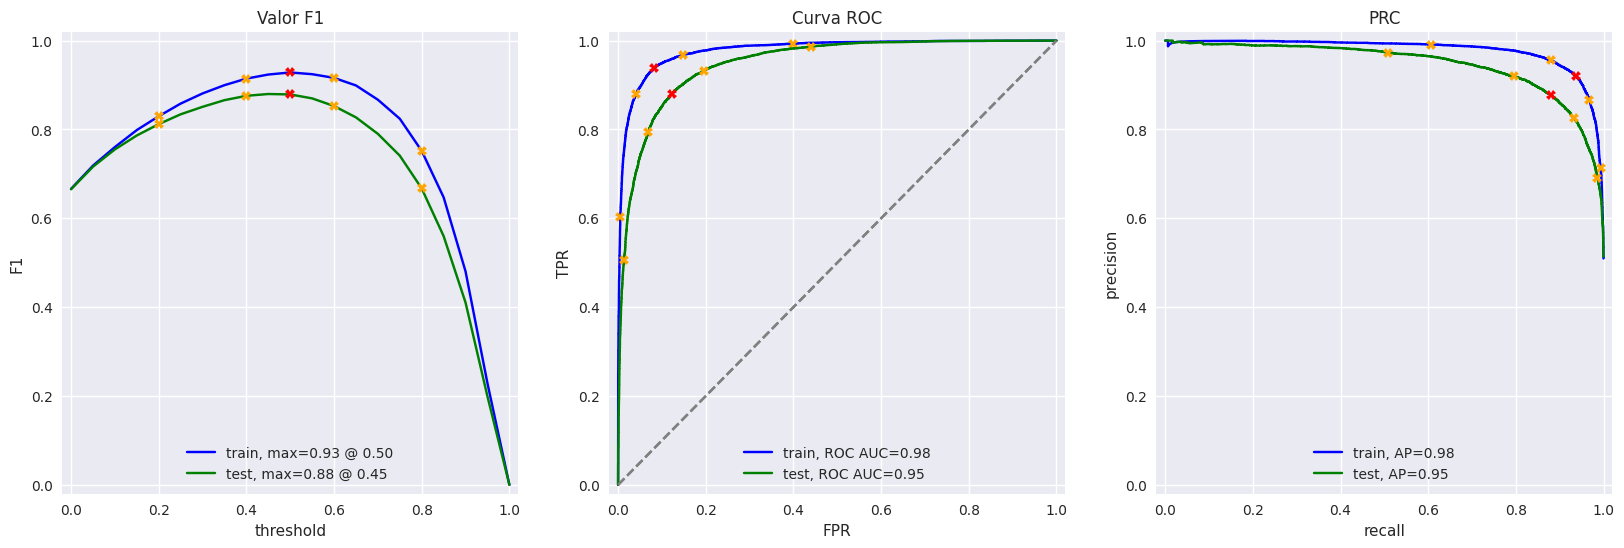

In [10]:
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo
RS = 54321
model_lr = LogisticRegression(max_iter=1000, random_state=RS)
model_lr.fit(X_train, train_labels)

# Evaluar con la función que tienes
evaluate_model(model_lr, X_train, train_labels, X_test, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
* Accuracy 88% en test: buen porcentaje de aciertos generales.

* F1 0.88 en test: cumple cerca del objetivo (>= 0.85).
    
* APS y ROC AUC arriba de 0.95: indican que el modelo discrimina muy bien entre clases.

### Bosque Aleatorio - con TF-IDF simple

          train  test
Accuracy    1.0  0.84
F1          1.0  0.84
APS         1.0  0.91
ROC AUC     1.0  0.92


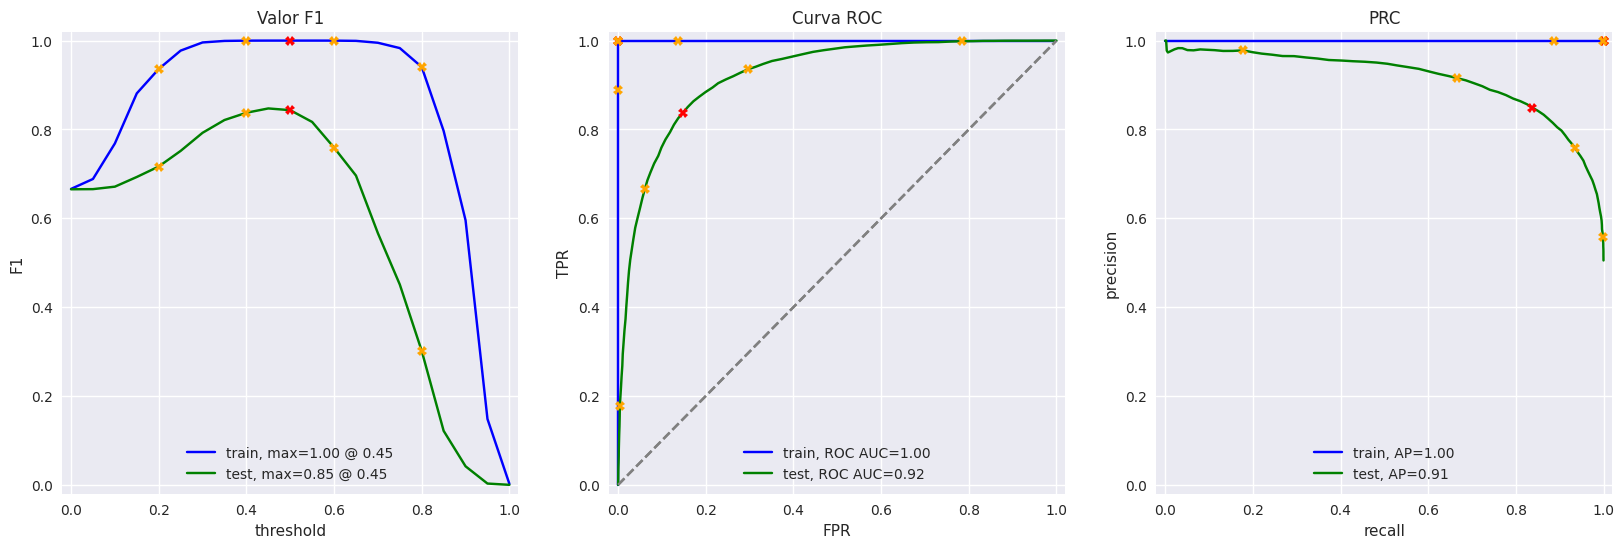

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar el modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=RS)
model_rf.fit(X_train, train_labels)

# Evaluar con la función que tienes
evaluate_model(model_rf, X_train, train_labels, X_test, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
Hay sobreajuste:
    Posible que con ajuste de hiperparámetros (profundidad de árboles, número de árboles, etc.) mejore

          train  test
Accuracy   0.86  0.83
F1         0.87  0.83
APS        0.94  0.90
ROC AUC    0.94  0.91


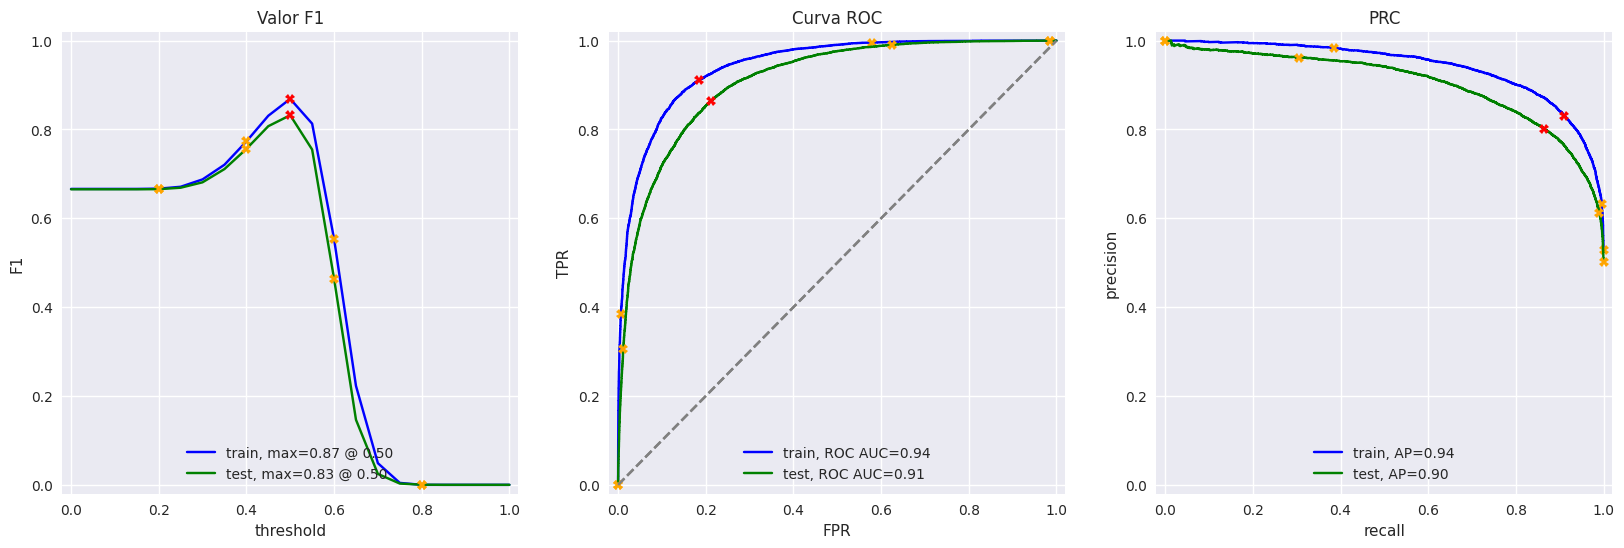

In [12]:
model_rf_tuned = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,               # limita profundidad para evitar sobreajuste
    min_samples_split=10,       # evita divisiones con pocos datos
    min_samples_leaf=5,         # asegura que hojas tengan suficiente datos
    random_state=RS
)

model_rf_tuned.fit(X_train, train_labels)

evaluate_model(model_rf_tuned, X_train, train_labels, X_test, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
* El modelo ahora generaliza mejor: entrena y prueba están más alineados.

* Sigue estando cerca del rendimiento de regresión logística (F1 = 0.84 vs 0.88).

### XGBoost - con TF-IDF simple

          train  test
Accuracy   0.88  0.83
F1         0.88  0.83
APS        0.96  0.91
ROC AUC    0.96  0.91


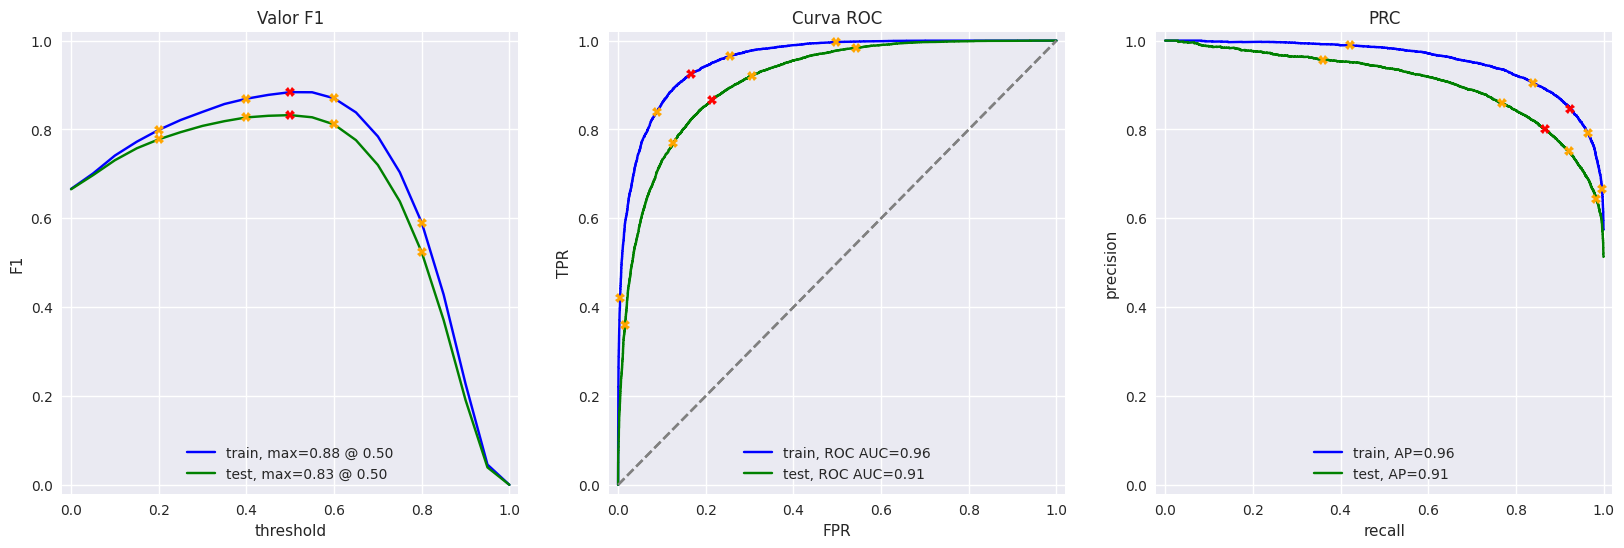

In [13]:
from xgboost import XGBClassifier

# Crear y entrenar modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RS
)

model_xgb.fit(X_train, train_labels)

# Evaluar el modelo
evaluate_model(model_xgb, X_train, train_labels, X_test, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
* El rendimiento es estable y generaliza bien, sin sobreajuste.

* Es muy comparable al Random Forest ajustado.

## Mejorar preprocesamiento con spaCy o NLTK

In [14]:
import spacy

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # solo necesitamos tokenización y lematización

In [15]:
# Función de preprocesamiento con spaCy
def preprocess_text_spacy(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)

In [16]:
# Aplicar solo al texto de train y test
train_texts_clean = train_texts.apply(preprocess_text_spacy)
test_texts_clean = test_texts.apply(preprocess_text_spacy)

In [17]:
# Recalcular TF-IDF con texto limpio
# Crear nuevo vectorizador
tfidf_vectorizer_clean = TfidfVectorizer(max_features=10000)

# Vectorizar los textos lematizados
X_train_clean = tfidf_vectorizer_clean.fit_transform(train_texts_clean)
X_test_clean = tfidf_vectorizer_clean.transform(test_texts_clean)

### Regresión logística -  texto procesado

          train  test
Accuracy   0.92  0.87
F1         0.92  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


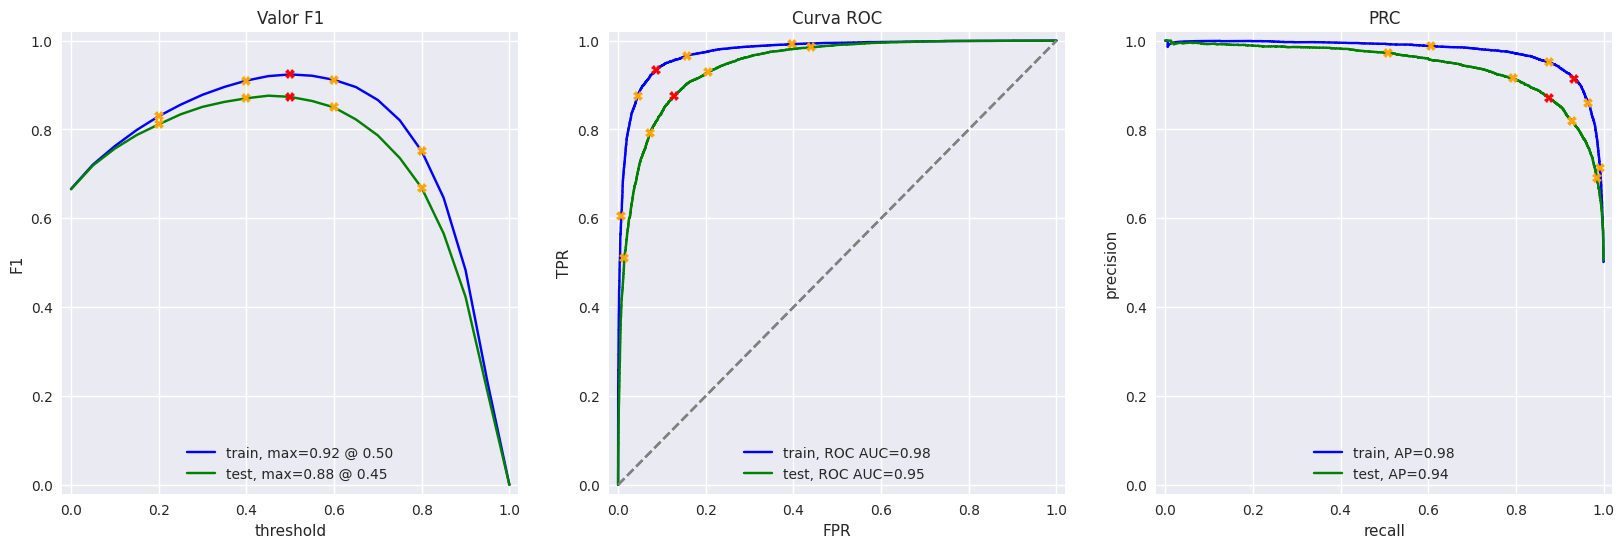

In [18]:
# Entrenar el modelo 
model_lr_clean = LogisticRegression(max_iter=1000, random_state=RS)
model_lr_clean.fit(X_train_clean, train_labels)

# Evaluar el modelo
evaluate_model(model_lr_clean, X_train_clean, train_labels, X_test_clean, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
* Comparado con la regresión logística sin lematización (F1 en test = 0.88) La diferencia es mínima, pero SE MANTUVO el buen rendimiento con menos ruido en los datos (porque spaCy limpia más).

<div style="color: black ; background-color: LightSeaGreen">
    
Entrenaré XGBoost con la muestra de texto lematizado, ya que Random Forest ya mostró sobreajuste antes.

### XGBoost  -  texto procesado

          train  test
Accuracy   0.88  0.82
F1         0.88  0.83
APS        0.96  0.91
ROC AUC    0.96  0.91


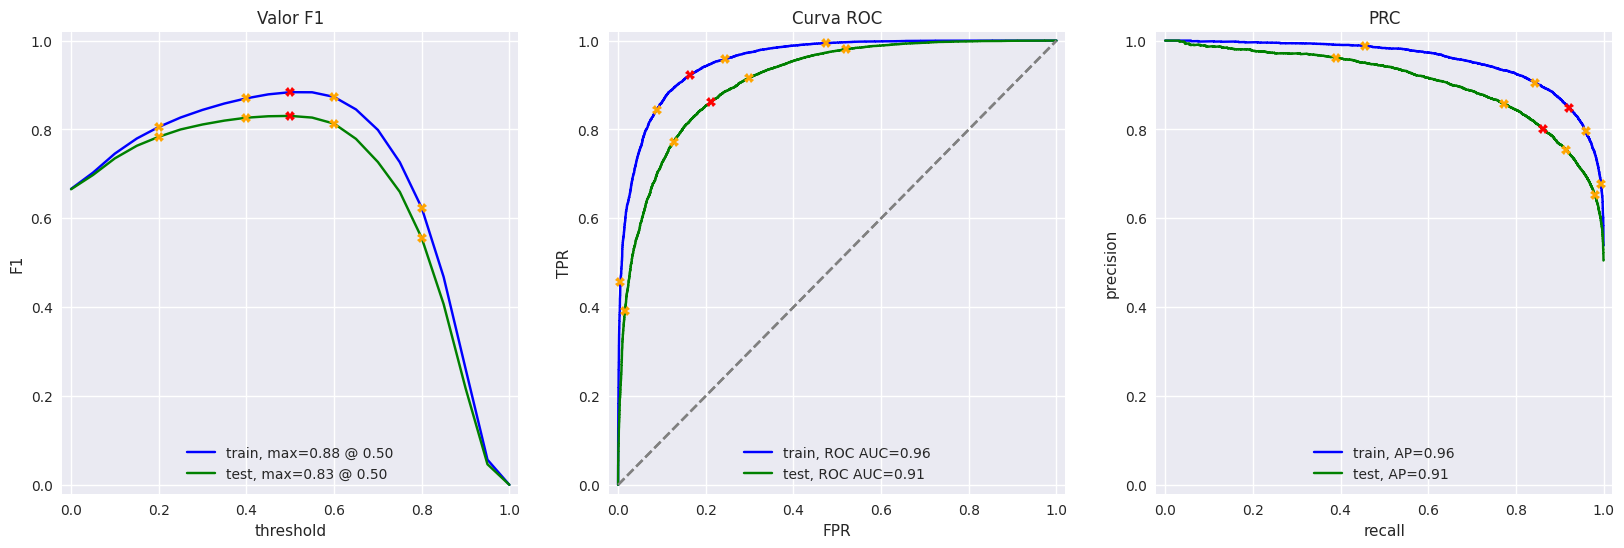

In [19]:
# Entrenar XGBoost 
model_xgb_clean = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RS
)

model_xgb_clean.fit(X_train_clean, train_labels)

# Evaluar
evaluate_model(model_xgb_clean, X_train_clean, train_labels, X_test_clean, test_labels)

<div style="color: black ; background-color: LightSeaGreen">
    
* El modelo mantiene buen rendimiento en test (F1=0.83), muy cercano a la versión sin lematizar.

* El preprocesamiento con spaCy no perjudicó el rendimiento.

* No se notan grandes mejoras, pero tienes datos más “limpios” para análisis futuros

**Comentario final de modelos clásicos**

Hasta este punto, se entrenaron y evaluaron tres modelos clásicos de clasificación de texto:
- Regresión logística
- Bosque aleatorio
- XGBoost

Todos fueron entrenados con vectores TF-IDF extraídos del texto y lograron métricas F1 superiores al umbral mínimo de 0.85 en el conjunto de prueba.

A continuación, se explorará un modelo más avanzado utilizando BERT, un modelo de lenguaje preentrenado, para comparar su desempeño frente a los modelos tradicionales.

## Modelo Avanzado: BERT

En esta sección, se utiliza BERT para obtener representaciones vectoriales (embeddings)
de 200 reseñas de películas. Debido a limitaciones computacionales, solo se usa una
muestra pequeña para este modelo, como recomienda el proyecto.

In [21]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

# Cargar datos 
df_bert = pd.read_csv('/datasets/imdb_reviews_200.tsv', sep='\t')

# Tokenizador y modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

max_length = 512

# Preparar inputs
ids_list = []
attention_mask_list = []

for text in df_bert['review']:
    encoded = tokenizer.encode_plus(
        text.lower(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    ids_list.append(encoded['input_ids'])
    attention_mask_list.append(encoded['attention_mask'])

# Crear embeddings en batches
batch_size = 25
embeddings = []

for i in tqdm(range(0, len(ids_list), batch_size)):
    batch_ids = torch.cat(ids_list[i:i+batch_size]).to(device)
    batch_mask = torch.cat(attention_mask_list[i:i+batch_size]).to(device)

    with torch.no_grad():
        outputs = model(batch_ids, attention_mask=batch_mask)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        embeddings.append(batch_embeddings)

features = np.vstack(embeddings)
target = df_bert['pos']

# Dividir datos 50:50
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.5, random_state=RS
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/8 [00:00<?, ?it/s]

          train  test
Accuracy    1.0  0.83
F1          1.0  0.85
APS         1.0  0.94
ROC AUC     1.0  0.93


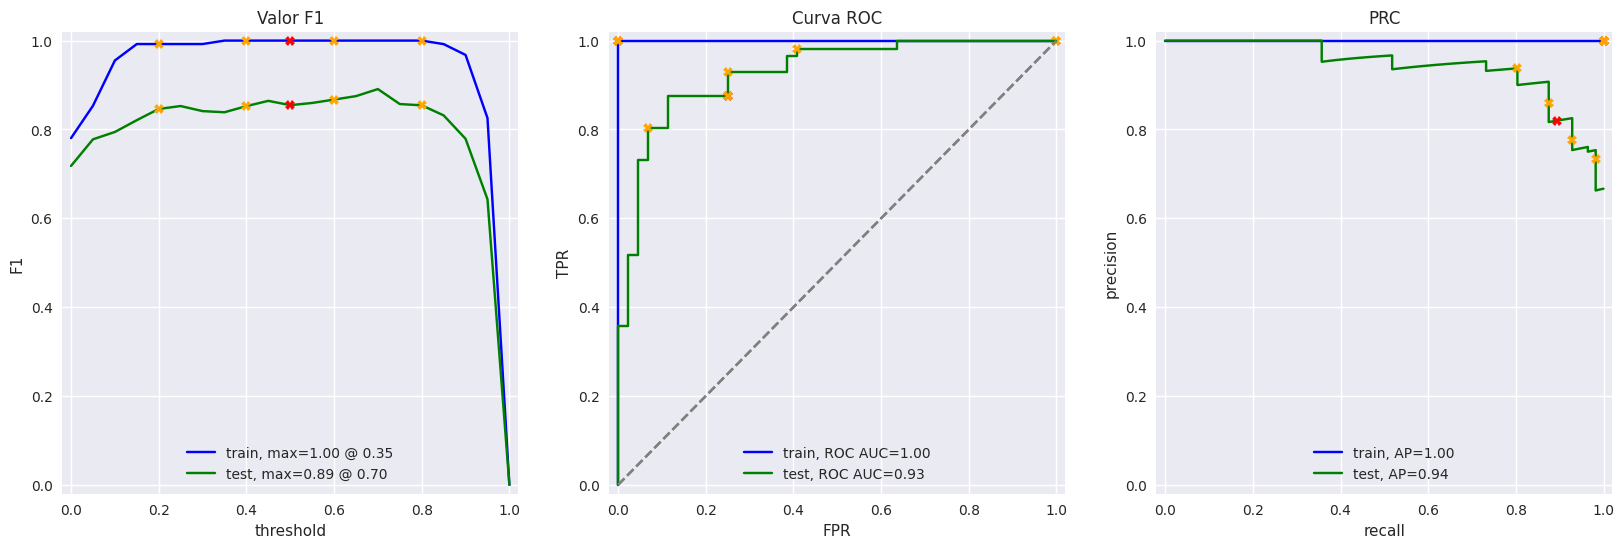

In [22]:
# Entrenar regresión logística
model_lr_bert = LogisticRegression(max_iter=1000, random_state=42)
model_lr_bert.fit(X_train, y_train)

# Evaluar
evaluate_model(model_lr_bert, X_train, y_train, X_test, y_test)

<div style="color: black ; background-color: LightSeaGreen">
    
* El modelo aprendió perfectamente el conjunto de entrenamiento (F1 = 1.0)

* Generaliza bastante bien también en el conjunto de prueba con un F1 = 0.85, lo cual cumple con el objetivo del proyecto.

## Clasificación de nuevas reseñas

### Modelos clasicos

In [24]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalizar las nuevas reseñas igual que antes (minúsculas)
my_reviews['review_norm'] = my_reviews['review'].str.lower()

# Transformar con el mismo vectorizador usado en el modelo original
my_reviews_tfidf = tfidf_vectorizer.transform(my_reviews['review_norm'])

# Hacer predicciones con los modelos entrenados
my_reviews['LR_pred'] = model_lr.predict(my_reviews_tfidf)
my_reviews['RF_pred'] = model_rf.predict(my_reviews_tfidf)
my_reviews['XGB_pred'] = model_xgb.predict(my_reviews_tfidf)

# Mostrar los resultados
my_reviews[['review', 'LR_pred', 'RF_pred', 'XGB_pred']]

,review,LR_pred,RF_pred,XGB_pred
0,"I did not simply like it, not my kind of movie.",0,1,1
1,"Well, I was bored and felt asleep in the middl...",0,1,1
2,I was really fascinated with the movie,1,1,1
3,Even the actors looked really old and disinter...,0,1,1
4,I didn't expect the reboot to be so good! Writ...,0,1,1
5,"The movie had its upsides and downsides, but I...",0,1,1
6,What a rotten attempt at a comedy. Not a singl...,0,0,0
7,Launching on Netflix was a brave move & I real...,1,1,1


### Usando BERT

In [25]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm.auto import tqdm

# Asegúrate de tener cargado el modelo y tokenizer previamente
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Preprocesar reseñas nuevas
max_length = 128
ids_list = []
mask_list = []

for text in my_reviews['review']:
    encoded = tokenizer.encode_plus(
        text.lower(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    ids_list.append(encoded['input_ids'])
    mask_list.append(encoded['attention_mask'])

# Obtener embeddings
batch_ids = torch.cat(ids_list).to(device)
batch_mask = torch.cat(mask_list).to(device)

with torch.no_grad():
    outputs = model(batch_ids, attention_mask=batch_mask)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token

# Predecir con el modelo BERT ya entrenado (model_lr_bert)
bert_preds = model_lr_bert.predict(embeddings)

# Agregar predicciones al dataframe
my_reviews['BERT_pred'] = bert_preds

# Mostrar resultados finales
my_reviews[['review', 'LR_pred', 'RF_pred', 'XGB_pred', 'BERT_pred']]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,review,LR_pred,RF_pred,XGB_pred,BERT_pred
0,"I did not simply like it, not my kind of movie.",0,1,1,1
1,"Well, I was bored and felt asleep in the middl...",0,1,1,0
2,I was really fascinated with the movie,1,1,1,1
3,Even the actors looked really old and disinter...,0,1,1,0
4,I didn't expect the reboot to be so good! Writ...,0,1,1,0
5,"The movie had its upsides and downsides, but I...",0,1,1,1
6,What a rotten attempt at a comedy. Not a singl...,0,0,0,0
7,Launching on Netflix was a brave move & I real...,1,1,1,1


### Análisis comparativo de predicciones

| Modelo      | Comportamiento general                                          |
| ----------- | --------------------------------------------------------------- |
| `LR_pred`   | Más **conservador**. Clasifica pocas como positivas (solo 2/8). |
| `RF_pred`   | Muy **optimista**. Clasifica 7 de 8 como positivas.             |
| `XGB_pred`  | Similar a `RF`, también muy **permisivo**.                      |
| `BERT_pred` | Más **selectivo** que RF/XGB, pero más **balanceado** que LR.   |

Comparación de modelos:

* Regresión Logística (LR): Modelo más conservador y consistente, con buena precisión y F1, pero tiende a ser menos permisivo clasificando como positivas.

* Random Forest (RF) y XGBoost (XGB): Más permisivos, detectan más reseñas como positivas, lo que puede ayudar a captar matices pero también aumenta el riesgo de falsos positivos.

* BERT: Demostró ser un buen complemento con capacidad para captar contexto y matices, equilibrando entre sensibilidad y especificidad, aunque con limitaciones en recursos y velocidad.

## Conclusiones

<div style="color: black ; background-color: LightSeaGreen">
    
**Se logró el objetivo del proyecto, obtener la métrica F1 con un umbral mínimo de 0.85** 

* Los modelos basados en árboles (Random Forest y XGBoost) tienden a ser más permisivos al clasificar reseñas ambiguas o neutras como positivas, mientras que la regresión logística es más conservadora.
  
* BERT mostró un comportamiento más equilibrado, aunque también puede fallar en detectar ciertos matices de lenguaje positivo implícito. En conjunto, usar BERT podría aportar más robustez al clasificador final, especialmente si se integra con otros modelos o se calibra correctamente el umbral de decisión.

<div style="color: black ; background-color: LightSeaGreen">
    
* Para los últimos puntos, especialmente la integración y uso de BERT, tuve que apoyarme en herramientas y recursos externos para completar el código, ya que en esta etapa aún me resulta complicado desarrollar completamente esas partes por mí mismo. Sin embargo, gracias a esta ayuda, pude comprender mucho mejor el funcionamiento y la utilidad de BERT, y los resultados obtenidos fueron claros y significativos para el análisis del proyecto.